In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


import warnings
warnings.filterwarnings('ignore')

In [36]:
end = '2019-12-31'
start = '1999-01-02'

trainingData = yf.download('^GSPC', start=start, end=end)
trainingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,1229.229980,1248.810059,1219.099976,1228.099976,1228.099976,877000000
1999-01-05,1228.099976,1246.109985,1228.099976,1244.780029,1244.780029,775000000
1999-01-06,1244.780029,1272.500000,1244.780029,1272.339966,1272.339966,986900000
1999-01-07,1272.339966,1272.339966,1257.680054,1269.729980,1269.729980,863000000
1999-01-08,1269.729980,1278.239990,1261.819946,1275.089966,1275.089966,937800000


In [37]:
end = '2024-03-30'
start = '2020-01-02'

testingData = yf.download('^GSPC', start=start, end=end)
testingData


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3459930000
2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3484700000
2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3702460000
2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3435910000
2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3726840000
...,...,...,...,...,...,...
2024-03-22,5242.479980,5246.089844,5229.870117,5234.180176,5234.180176,3374700000
2024-03-25,5219.520020,5229.089844,5216.089844,5218.189941,5218.189941,3331360000
2024-03-26,5228.850098,5235.160156,5203.419922,5203.580078,5203.580078,3871790000


In [38]:
trainprice = trainingData['Adj Close']
trainData = trainprice.values

testprice = testingData['Adj Close']
testData = testprice.values

In [39]:
trainData


array([1228.09997559, 1244.7800293 , 1272.33996582, ..., 3239.90991211,
       3240.02001953, 3221.29003906])

In [40]:
sc = MinMaxScaler(feature_range=(0,1))
trainDataScaled = sc.fit_transform(trainData.reshape(-1, 1))
testDataScaled = sc.fit_transform(testData.reshape(-1, 1))

In [41]:
n_steps = 20

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])

xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))


In [42]:
#LSTM Model

model = Sequential()

#Layer 1
model.add(LSTM(units=200,return_sequences=True,input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
#Layer 2
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 3
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 4
model.add(LSTM(units=200, return_sequences=False))
model.add(Dropout(0.2))
#Layer 5
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

#Early stopping parameters to stop unnecessary training
earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    mode='min',
    min_delta = 0.000001
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 200)           161600    
                                                                 
 dropout_4 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_5 (LSTM)               (None, 20, 200)           320800    
                                                                 
 dropout_5 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_6 (LSTM)               (None, 20, 200)           320800    
                                                                 
 dropout_6 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_7 (LSTM)               (None, 200)              

In [43]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [44]:
eval = model.evaluate(xTrain, yTrain)

165/165 [==============================] - 20s 103ms/step - loss: 0.1685 - root_mean_squared_error: 0.4105 - mean_absolute_error: 0.3447


In [45]:
len(xTrain)

5262

Epoch 1/100
31/31 [==============================] - 28s 610ms/step - loss: 0.0129 - root_mean_squared_error: 0.1134 - mean_absolute_error: 0.0928 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0948 - val_mean_absolute_error: 0.0768
Epoch 2/100
31/31 [==============================] - 18s 577ms/step - loss: 0.0127 - root_mean_squared_error: 0.1129 - mean_absolute_error: 0.0959 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1936 - val_mean_absolute_error: 0.1720
Epoch 3/100
31/31 [==============================] - 19s 618ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024 - mean_absolute_error: 0.0898 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1790 - val_mean_absolute_error: 0.1462
Epoch 4/100
31/31 [==============================] - 19s 605ms/step - loss: 0.0112 - root_mean_squared_error: 0.1059 - mean_absolute_error: 0.0893 - val_loss: 0.1125 - val_root_mean_squared_error: 0.3354 - val_mean_absolute_error: 0.3119
Epoch 5/100
31/31 [=============================

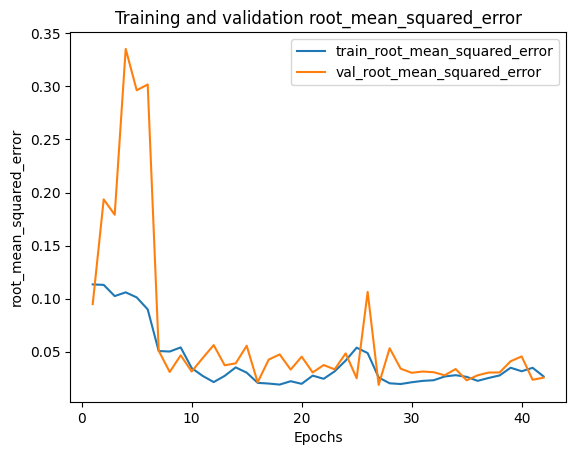

In [46]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=128,
    validation_split = 0.25,
    verbose=1,
    callbacks=[earlyStopping],
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [48]:
n_steps = 20

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])

xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))


In [49]:
predictions = model.predict(xTest) #Prediction on Data using trained model
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE
rmse

33/33 [==============================] - 4s 64ms/step


0.03804925132173126

In [50]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

33/33 [==============================] - 2s 69ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - mean_absolute_error: 0.0276


In [51]:
df1 = pd.DataFrame(testingData['Adj Close']).astype(float)
df1 = df1.iloc[:-20]
df1 = df1.reset_index(drop=False)

df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)


In [52]:
df = df1.join(df2)
df = df.set_index('Date')
df

,Adj Close,Pred Adj Close
Date,,
2020-01-02,3257.850098,3368.229248
2020-01-03,3234.850098,3363.258545
2020-01-06,3246.280029,3357.395996
2020-01-07,3237.179932,3352.910156
2020-01-08,3253.050049,3352.070557
...,...,...
2024-02-23,5088.799805,5048.765137
2024-02-26,5069.529785,5056.148926
2024-02-27,5078.180176,5063.734375


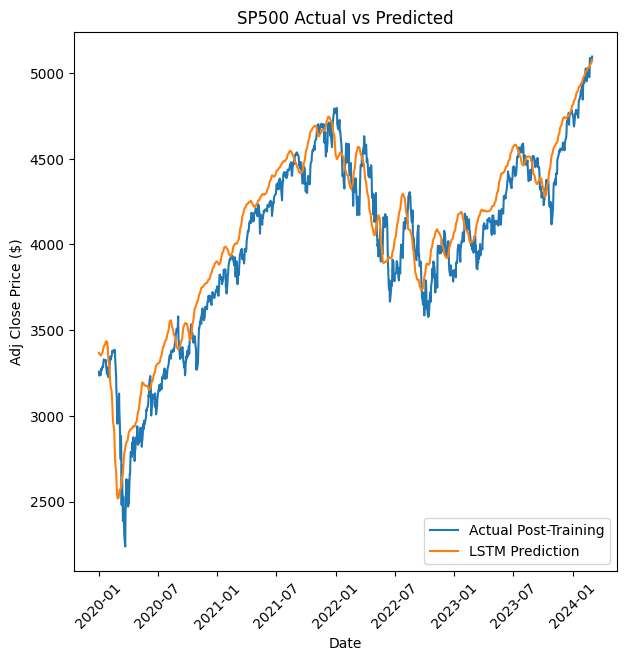

In [56]:
real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(7,7))
plt.title('SP500 Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Post-Training','LSTM Prediction'], loc='lower right')

plt.xticks(rotation=45)
plt.show()

In [57]:
import numpy as np
import pandas as pd

last_sequence = testDataScaled[-n_steps:].reshape(1, n_steps, 1)
future_predictions = []
for _ in range(23):
    next_day_pred = model.predict(last_sequence)
    future_predictions.append(next_day_pred.flatten()[0])
    last_sequence = np.append(last_sequence[:, 1:, :], np.expand_dims(next_day_pred, axis=1), axis=1)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = sc.inverse_transform(future_predictions)

last_date = testingData.index.max()
# Using bdate_range to ensure only business days are included
predicted_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=23, freq='B')

predicted_df = pd.DataFrame(future_predictions, index=predicted_dates, columns=['Predicted Adj Close'])
print(predicted_df)


1/1 [==============================] - 0s 37ms/step
            Predicted Adj Close
2024-03-29          5082.575684
2024-04-01          5084.854980
2024-04-02          5082.548340
2024-04-03          5076.437012
2024-04-04          5067.634277
2024-04-05          5057.316406
2024-04-08          5046.571289
2024-04-09          5035.844727
2024-04-10          5025.264648
2024-04-11          5015.111816
2024-04-12          5005.399414
2024-04-15          4996.139648
2024-04-16          4987.138672
2024-04-17          4978.401855
2024-04-18          4969.884766
2024-04-19          4961.657227
2024-04-22          4953.755371
2024-04-23          4946.174805
2024-04-24          4938.889160
2024-04-25          4931.745605
2024-04-26          4924.856445
2024-04-29          4918.600098
2024-04-30          4912.478516


In [63]:
predicted_df

,Predicted Adj Close
2024-03-29,5082.575684
2024-04-01,5084.854980
2024-04-02,5082.548340
2024-04-03,5076.437012
2024-04-04,5067.634277
2024-04-05,5057.316406
2024-04-08,5046.571289
2024-04-09,5035.844727
2024-04-10,5025.264648
2024-04-11,5015.111816


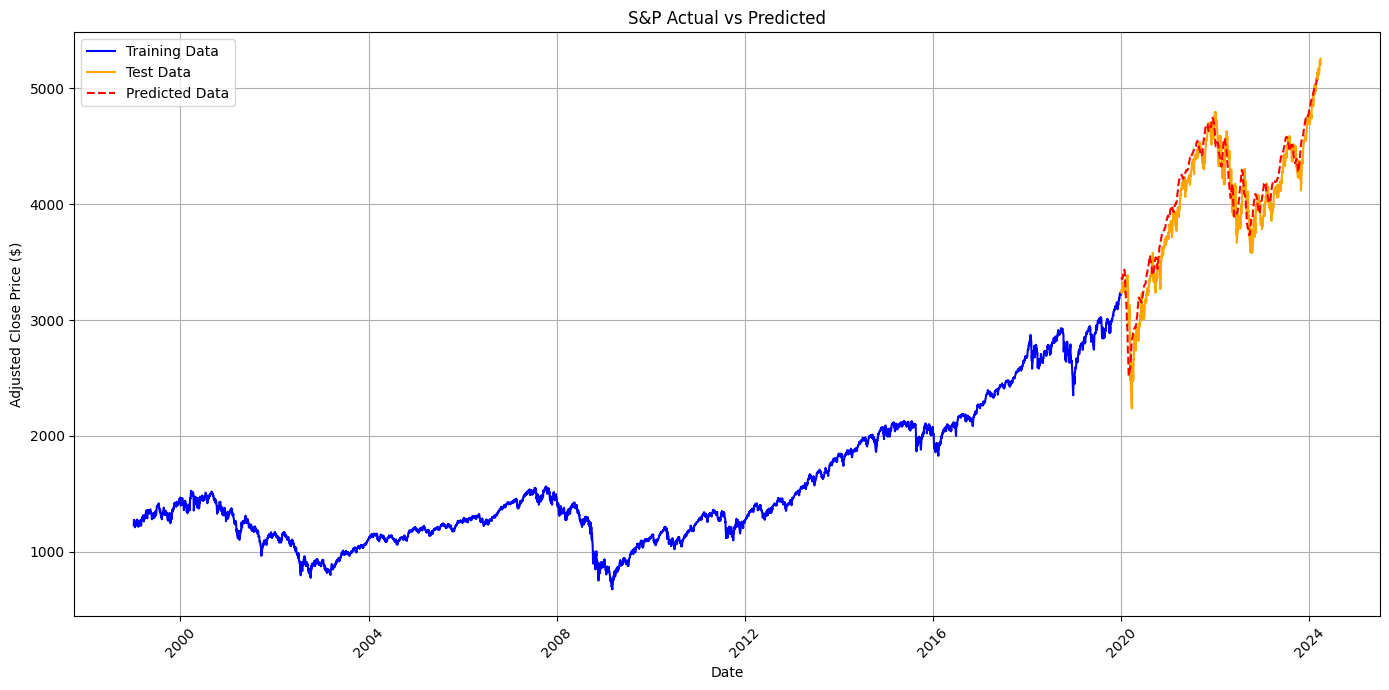

In [62]:
import matplotlib.pyplot as plt


train = trainingData['Adj Close']
real = testingData['Adj Close']
pred = df['Pred Adj Close']

plt.figure(figsize=(14, 7))
plt.title('S&P Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')


plt.plot(trainingData.index, train, label='Training Data', color='blue')
plt.plot(testingData.index, real, label='Test Data', color='orange')
plt.plot(df.index, pred, label='Predicted Data', color='red', linestyle='--')

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
